In [84]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy

sns.set()
%matplotlib inline

## A Comparison of MLE vs. Imputation for Monotone Data ##

Here, we consider a simplified model where we have samples $X_1, X_2, \dots, X_{m+n} \sim \mathcal{N}(0, \Sigma)$.  However, our observations are such that $X_1, \dots X_n$ are observed fully, but $X_{n+1}, \dots, X_{n + m}$ are observed only on the first $k$ entries, where $X_i \in \mathbb{R}^{p}$.  

### Exact MLE Computation
In this case, we let $V = \frac{1}{n}\sum_{i=1}^{n}x_i x_i^{T}$ and $W = \frac{1}{m}\sum_{i=n+1}^{m+n} x_i x_i^{T}$ so that we have the likelihood:
$$
\ell(\Sigma) = n \log{|\Sigma|} - n \text{Tr}\Sigma^{-1}V - m
\log{|\Sigma_{11}|} - m \text{Tr}\Sigma_{11}^{-1}W
$$
Maximizing with respect to $\Sigma$ gives:
- $\hat{\Sigma}_{11} = \frac{1}{n + m}(nV_{11} + mW)$
- $\hat{\Sigma}_{12} =
\frac{1}{n+m}(nV_{11} + mW)V_{11}^{-1}V_{12}$
- $\hat{\Sigma}_{22} = V_{22} -
\frac{m}{n+m}V_{21}V_{11}^{-1}V_{12} +
\frac{m}{m+n}V_{21}V_{11}^{-1}WV_{11}^{-1}V_{12}$

Finally, although our MLE is computed in close form for arbitrary covariance matrices, we will simulate using $\Sigma_{ij} = \rho^{|i - j|}$ for different values of $\rho$.

The parameters we can tune here are $k$, the entries observed; $\frac{n}{m+n}$, the fraction of complete observations; and $\rho$, the parameter governing correlation.

### Experiment set-up
We consider a regression setting in which we observe $y = \beta^{T} X$ and $\tilde{X}$, the data matrix with monotone missingness.  We generate $\beta$ randomly.  Using the methods:
1. Complete case analysis + linear regression
2. Mean imputation + linear regression
3. MLE estimation of covariance matrix (linear regression follows from this)

In [88]:
### Model Generation ###
n, m = 1000, 200 # number of samples
k, p = 5, 10 # dimension of signal
rho = 0.5 # correlation parameter

# Generate covariance matrix
mu = np.zeros(p) # mean matrix
sigma = np.zeros([p,p]) 
for i in range(p):
    for j in range(p):
        sigma[i,j] = rho**(np.abs(i - j))

X = np.random.multivariate_normal(mu, sigma, m + n) # generate underlying data

# Generate monotone data
X_tilde = copy.deepcopy(X)
for i in range(m + n):
    for j in range(p):
        if i > 1000 and j > k:
            X_tilde[i,j] = np.nan
            
beta = np.random.normal(0, 1, p) # Random weights for regression
y = X @ beta

array([ -2.32570559,   2.54132135,  -7.92576962, ...,  11.0751279 ,
         4.82347457,   5.27195855])

In [91]:
### MLE Solution ###
V, W = np.zeros([p,p]), np.zeros([k,k])
for i in range(n):
    V += np.outer(X_tilde[i], X_tilde[i].T)
for i in range(n, n+m):
    W += np.outer(X_tilde[i,:k], X_tilde[i,:k].T)
V, W = V/n, W/n

V_11, V_12, V_21, V_22 = V[:k,:k], V[:k, p-k:p], V[p-k:p, :k], V[p-k:p, p-k:p]
V_11_inv = np.linalg.inv(V_11)

sigma_est = np.zeros([p,p])

### First the upper left block
sigma_est[:k, :k] = 1/(n + m) * (n * V_11 + m * W)

### Upper right block
sigma_est[:k, p-k:p] =1/(n + m) * (n * V_11 + m * W) @ V_11_inv @ V_12

### Lower left block
sigma_est[p-k:p, :k] = (1/(n + m) * (n * V_11 + m * W) @ V_11_inv @ V_12).T

### Lower right block
sigma_est[p-k:p, p-k:p] = V_22 - (m/(n+m))*V_21 @ V_11_inv @ V_12 + (m/(m+n)) * V_21 @ V_11_inv @ W @ V_11_inv @ V_12

sigma_est_11_inv = np.linalg.inv(sigma_est[:k,:k]) # The inverse of the upper left block

We now impute the missing data using MMSE estimates from the estimated $\hat{\Sigma}$.  Since the data is assumed to be Gaussian, the MMSE is the LLSE, implying that if the column $i > k$ is missing and the observed samples are $X_1, X_2, \dots, X_k$, then the MMSE estimate of $X_i$ is:
$$
(\hat{\Sigma}_{1, i}, \hat{\Sigma}_{2, i}, \dots, \hat{\Sigma}_{k,i})\hat{\Sigma}_{11}^{-1}(X_1, X_2, \dots, X_k)^T
$$

In [110]:
X_mle = copy.deepcopy(X_tilde)
for i in range(X_tilde.shape[0]):
    for j in range(X_tilde.shape[1]):
        if j > k and np.isnan(X_tilde[i,j]):
            cov_vec = sigma_est[j, :k]
            observed_vec = X_tilde[i,:k]
            X_mle[i,j] = cov_vec @ sigma_est_11_inv @ observed_vec
            

beta_mle = np.linalg.lstsq(X_mle, y)[0]

[ 0.89513949  0.55825204  4.20010852 -0.25027423 -1.6522864   1.74695348
 -0.01867082  0.33170021  1.22979563 -0.54216033]
0.00232458288552


In [251]:
class MonotoneImpute:
    
    def __init__(self, k, p, m, n):
        self.n = n # Number of fully observed samples
        self.m = m # Number of partially observed samples
        self.k = k # Partial observations
        self.p = p # number of "features"
        
    def generate_parameters(self, rho):
        m, n, k, p = self.m, self.n, self.k, self.p
        self.mu = np.zeros(p) # mean matrix
        sigma = np.zeros([p,p]) 
        for i in range(p):
            for j in range(p):
                sigma[i,j] = rho**(np.abs(i - j))

        X = np.random.multivariate_normal(mu, sigma, m + n) # generate underlying data

        # Generate monotone data
        X_tilde = copy.deepcopy(X)
        for i in range(m + n):
            for j in range(p):
                if i > n and j > k:
                    X_tilde[i,j] = np.nan

        beta = np.random.normal(0, 1, p) # Random weights for regression
        y = X @ beta
        
        self.sigma = sigma
        self.X = X
        self.X_tilde = X_tilde
        self.y = y
        self.beta = beta
        
    def mle_solution(self):
        k, p, n, m, X_tilde = self.k, self.p, self.n, self.m, self.X_tilde
        V, W = np.zeros([p,p]), np.zeros([k,k])
        for i in range(n):
            V += np.outer(X_tilde[i], X_tilde[i].T)
        for i in range(n, n+m):
            W += np.outer(X_tilde[i,:k], X_tilde[i,:k].T)
        V, W = V/n, W/n

        V_11, V_12, V_21, V_22 = V[:k,:k], V[:k, p-k:p], V[p-k:p, :k], V[p-k:p, p-k:p]
        V_11_inv = np.linalg.inv(V_11)

        sigma_est = np.zeros([p,p])

        ### First the upper left block
        sigma_est[:k, :k] = 1/(n + m) * (n * V_11 + m * W)

        ### Upper right block
        sigma_est[:k, p-k:p] =1/(n + m) * (n * V_11 + m * W) @ V_11_inv @ V_12

        ### Lower left block
        sigma_est[p-k:p, :k] = (1/(n + m) * (n * V_11 + m * W) @ V_11_inv @ V_12).T

        ### Lower right block
        sigma_est[p-k:p, p-k:p] = V_22 - (m/(n+m))*V_21 @ V_11_inv @ V_12 + (m/(m+n)) * V_21 @ V_11_inv @ W @ V_11_inv @ V_12

        sigma_est_11_inv = np.linalg.inv(sigma_est[:k,:k]) # The inverse of the upper left block
        
        X_mle = copy.deepcopy(X_tilde)
        for i in range(X_tilde.shape[0]):
            for j in range(X_tilde.shape[1]):
                if j > k and np.isnan(X_tilde[i,j]):
                    cov_vec = sigma_est[j, :k]
                    observed_vec = X_tilde[i,:k]
                    X_mle[i,j] = cov_vec @ sigma_est_11_inv @ observed_vec


        beta_mle = np.linalg.lstsq(X_mle, self.y)[0]
        return beta_mle
    
    def cc_solution(self):
        k, p, n, m, X_tilde = self.k, self.p, self.n, self.m, self.X_tilde
        beta_cc = np.linalg.lstsq(self.X[:n], self.y[:n])[0]

        return beta_cc
    
    def mi_solution(self):
        X_tilde = self.X_tilde
        X_mi = copy.deepcopy(X_tilde)
        for i in range(self.m+self.n):
            for j in range(p):
                if np.isnan(X_mi[i,j]):
                    X_mi[i,j] = 0
        
        beta_mi = np.linalg.lstsq(X_mi[:,:self.k], self.y)[0]
        if beta_mi.shape[0] < self.p:
            # Place 0
            temp = np.zeros(self.p)
            for idx in range(self.p):
                try:
                    temp[idx] = beta_mi[idx]
                except IndexError as e:
                    temp[idx] = 0
            beta_mi = temp
        return beta_mi
        
    def run_simulations(self, rho_sequence):
        mle_error, cc_error, mi_error = [], [], []
        for rho in rho_sequence:
            new_X = np.random.multivariate_normal(mu, sigma, 10)
            self.generate_parameters(rho)
            mle_error.append(np.sum((new_X @ self.mle_solution() - new_X @ self.beta)**2)/(self.n + self.m))
            cc_error.append(np.sum((new_X @ self.cc_solution() - new_X @ self.beta)**2)/(self.n + self.m))
            mi_error.append(np.sum((new_X @ self.mi_solution() - new_X @ self.beta)**2)/(self.n + self.m))

        plt.figure(figsize=(10,8))
        plt.plot(rho_sequence, mle_error, label="MLE Error")
        plt.plot(rho_sequence, cc_error, label="CC Error")
        plt.plot(rho_sequence, mi_error, label="MI Error")
        plt.legend()
        plt.xlabel('rho')
        plt.ylabel('MSE')
        plt.yscale('log')
        plt.title("Comparison of Imputation Methods -- Overall")
        
        plt.figure(figsize=(10,8))
        plt.plot(rho_sequence, mle_error, label="MLE Error")
        plt.plot(rho_sequence, cc_error, label="CC Error")
#         plt.plot(rho_sequence, mi_error, label="MI Error")
        plt.legend()
        plt.xlabel('rho')
        plt.ylabel('MSE')
        plt.yscale('log')
#         plt.ylim([0,10**2])
        plt.title("Comparison of Imputation Methods -- No MI")

### Some Experiments ###
In the class MonotoneImpute, the first parameter is $k$, the number of rows we observe in the missing cases, the second parameter is $p$, the total dimension of the complete data, the third parameter is $m$, the number of incomplete cases we observe, and the last is $n$ the number of complete cases we observe.

Here, we try $k=2$, $p=10$.

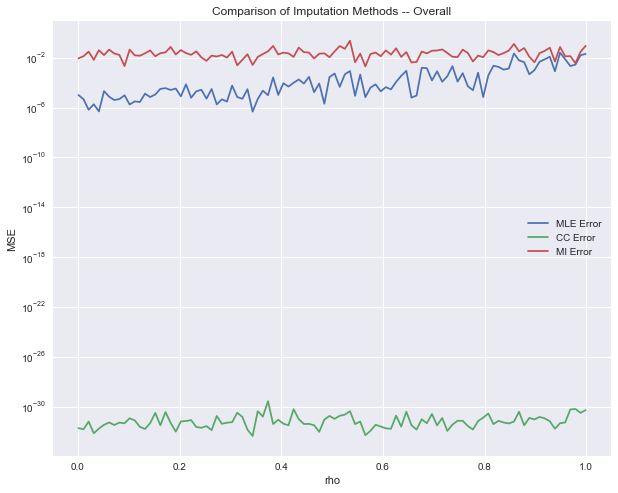

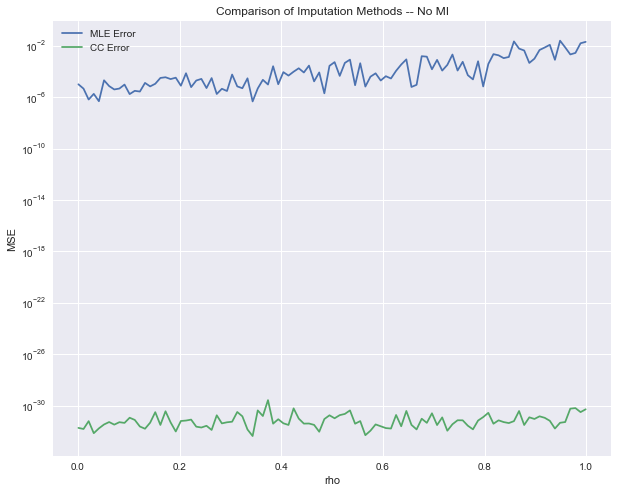

In [252]:
tester = MonotoneImpute(2, 10, 1000, 2000)
tester.run_simulations(np.linspace(0.001, 0.999, 100))

It seems fairly clear that in the above comparison, the complete case analysis performs well.  This is likely due to the large number of cases which are fully observed, so we keep the same $k, p$ parameters and alter the $m, n$

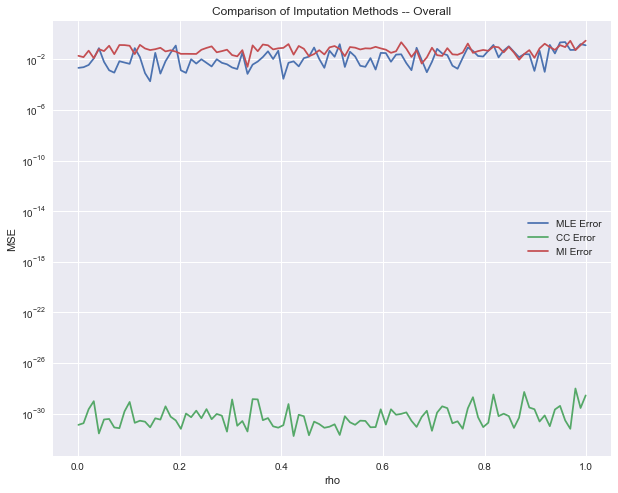

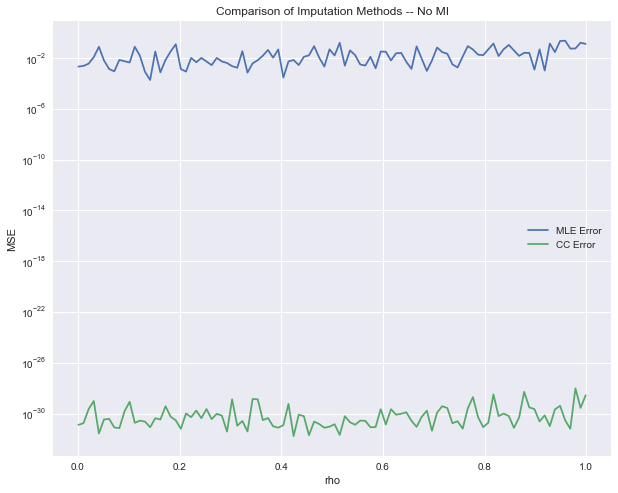

In [253]:
tester = MonotoneImpute(2, 10, 1000, 10)
tester.run_simulations(np.linspace(0.001, 0.999, 100))

Surprisingly, even with only $10$ fully observed cases, complete case analysis seems to perform the best.  Let's now try playing with $k,p$, this time setting $k=5, p=10$  

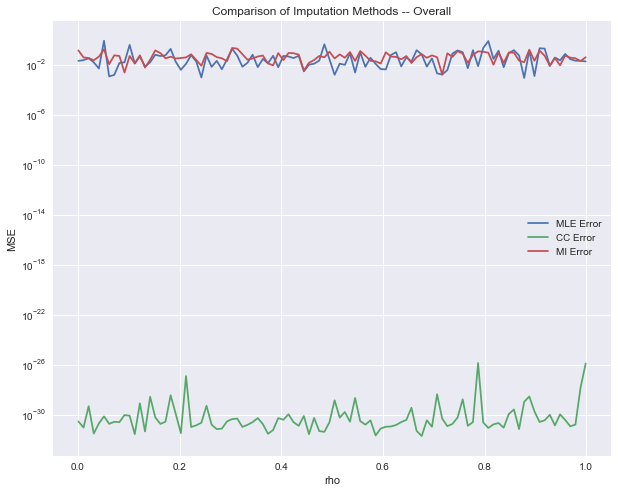

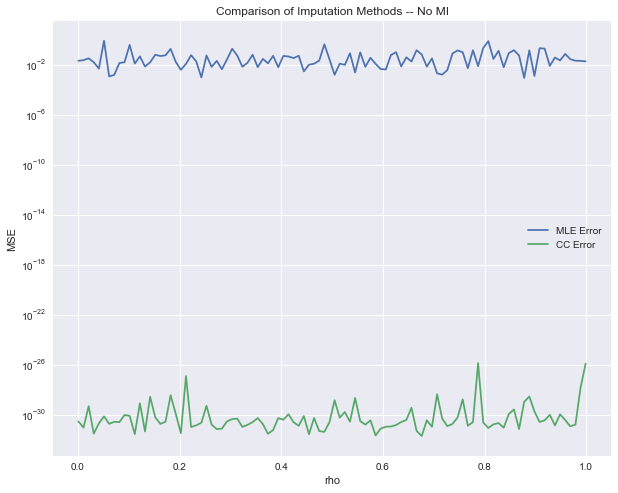

In [254]:
tester = MonotoneImpute(5, 10, 1000, 10)
tester.run_simulations(np.linspace(0.001, 0.999, 100))

Again, even on a small number of complete cases, CC analysis seems to perform the best, so we move to $k=9$.

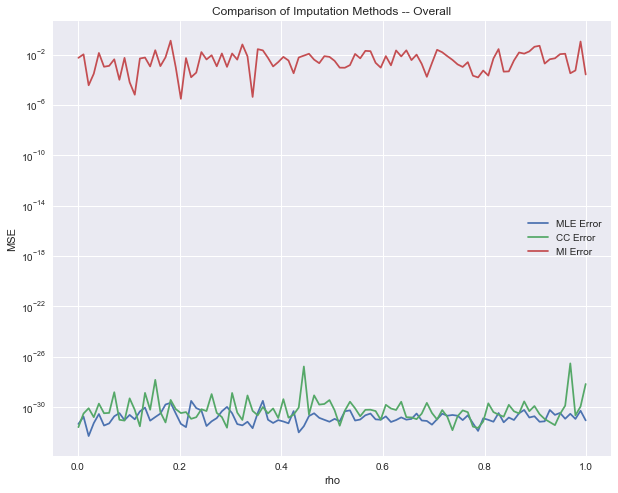

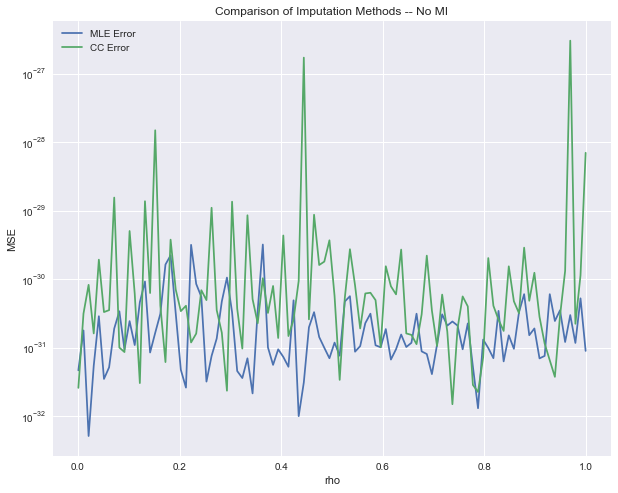

In [255]:
tester = MonotoneImpute(9, 10, 1000, 10)
tester.run_simulations(np.linspace(0.001, 0.999, 100))

Here we see the first case in which MLE performs similarly, but it is rather restrictive (only $10$ complete cases, so we try again with $1000$ complete cases)

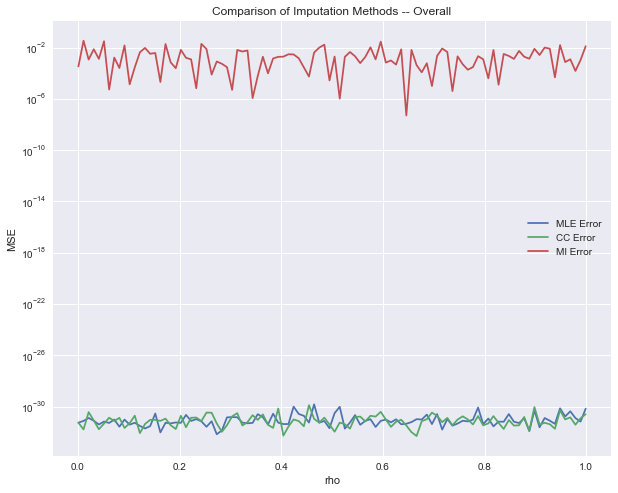

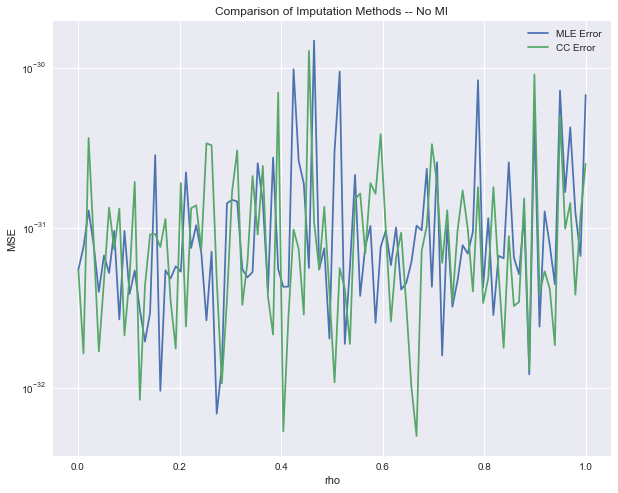

In [256]:
tester = MonotoneImpute(9, 10, 1000, 1000)
tester.run_simulations(np.linspace(0.001, 0.999, 100))